# Generiranje novih molekul

Variacijski avtokodirnik omogoča generiranje novih molekulskih struktur. Glavni razlog pri tem je, da uporablja dodatno cenovno funkcijo, ki deluje kot regularizacijska funkcija in prisili kodirnik zveznost latentnega prostora.
Variacijski avtokodirnik uporablja dodatno cenovno funkcijo, ki deluje kot regularizacijska funkcija in prisili kodirnik k zveznosti latentnega prostora.  
  
Eden izmed načinov za to je, vstaviti dve molekuli v latentni prostor našega variacijskega avtokodinrika. Vzamemo interpolacijo poti med tema dvema vektorjema in jih dekodiramo nazaj v zapis SMILES.  
Najprej je potrebno naložiti kodirniški in dekodirniški del avtokodirnika in podatke. Izbrali smo dve molekuli iz datoteke BBBP.csv z lastnostjo, da prehajajo skozi krvno-možgansko pregrado.

In [81]:
import re
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem, Draw
from rdkit.Chem.Draw import DrawingOptions
from scipy.interpolate import interp1d

import sys
sys.path.insert(0, '../code')
import cheauder_utils
from vae_smiles import CustomVariationalLayer

encoder = cheauder_utils.load_coder_json("../code/model/encoder.json",
                                         "../code/weights/encoder_weights.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 196})


decoder = cheauder_utils.load_coder_json("../code/model/decoder.json",
                                         "../code/weights/decoder_weights.h5",
                                         custom_objects={'CustomVariationalLayer': CustomVariationalLayer,
                                                  'latent_dim': 196})

smiles, y, label = cheauder_utils.read_data('../data/BBBP.csv', col_smiles=3, col_target=2, delimiter=',')
sms = smiles[y == '1'][:2]
chars, charset = cheauder_utils.load_charset('../code/model/charset_ZINC.json')
oh_sms = cheauder_utils.vectorize_smiles(sms, charset, 120)
encoded,_,_ = encoder.predict(oh_sms)

Nove vektorje ustvarimo kot interpolacijo poti med vzetima vektorjema. Ker je kodiranje probabilistično, dobljenim vektorjem dodamo šum in pogledamo, če dobimo veljaven zapis SMILES. Naredimo 1000 poskusov, ali dokler nam ne uspe dobiti veljavno molekulo.   

In [103]:
linfit = interp1d([1,10], np.vstack([encoded[0], encoded[1]]), axis=0)
inter = linfit(range(2,10))
res = [sms[0]]
for x in inter:
    for i in range(1000):
        pred = decoder.predict(np.array([cheauder_utils.perturb_z(x, noise_norm=3)]))[0]
        pred = np.array((pred.argmax(axis=1)[:, None] == np.arange(pred.shape[1])).astype(int))
        pred = cheauder_utils.devectorize_smile(pred, chars)
        pred = pred.split()[0]
        if cheauder_utils.is_valid_smiles(pred):
            res.append(pred)
            break
res.append(sms[1])
res

['[Cl].CC(C)NCC(O)COc1cccc2ccccc12',
 'C=C(CCCC#N)C(=O)COc1cccc2ccccc12',
 'C=C(CCCC#C)C(=O)COc1cccc2ccccc12',
 'Cn1=c(CC#C)CC(O)CCcccccc2cc2cc1CCC',
 'CC(=C(CC=C)CC=O)CCOc1ccc2ccccc12CC',
 'C[C@](CC(C)(C)C)CCOc1ccc2c(c1)OCCC2',
 'C[C@](CC(C)(C)C)CCOc1ccc2c(c1)CCCC2',
 'C[C@](CC(C)(C)C)CCOc1ccc2c(c1C1OCC2)CC1',
 'C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl']

Vse zapise SMILES izrišemo. Slike beremo kot od leve proti desni, in od zgoraj navzdol. Prva in zadnja molekuli sta vzeti iz podatkov, vmesne so bile zgrajene z našim variacijskim avtokodirnikom.

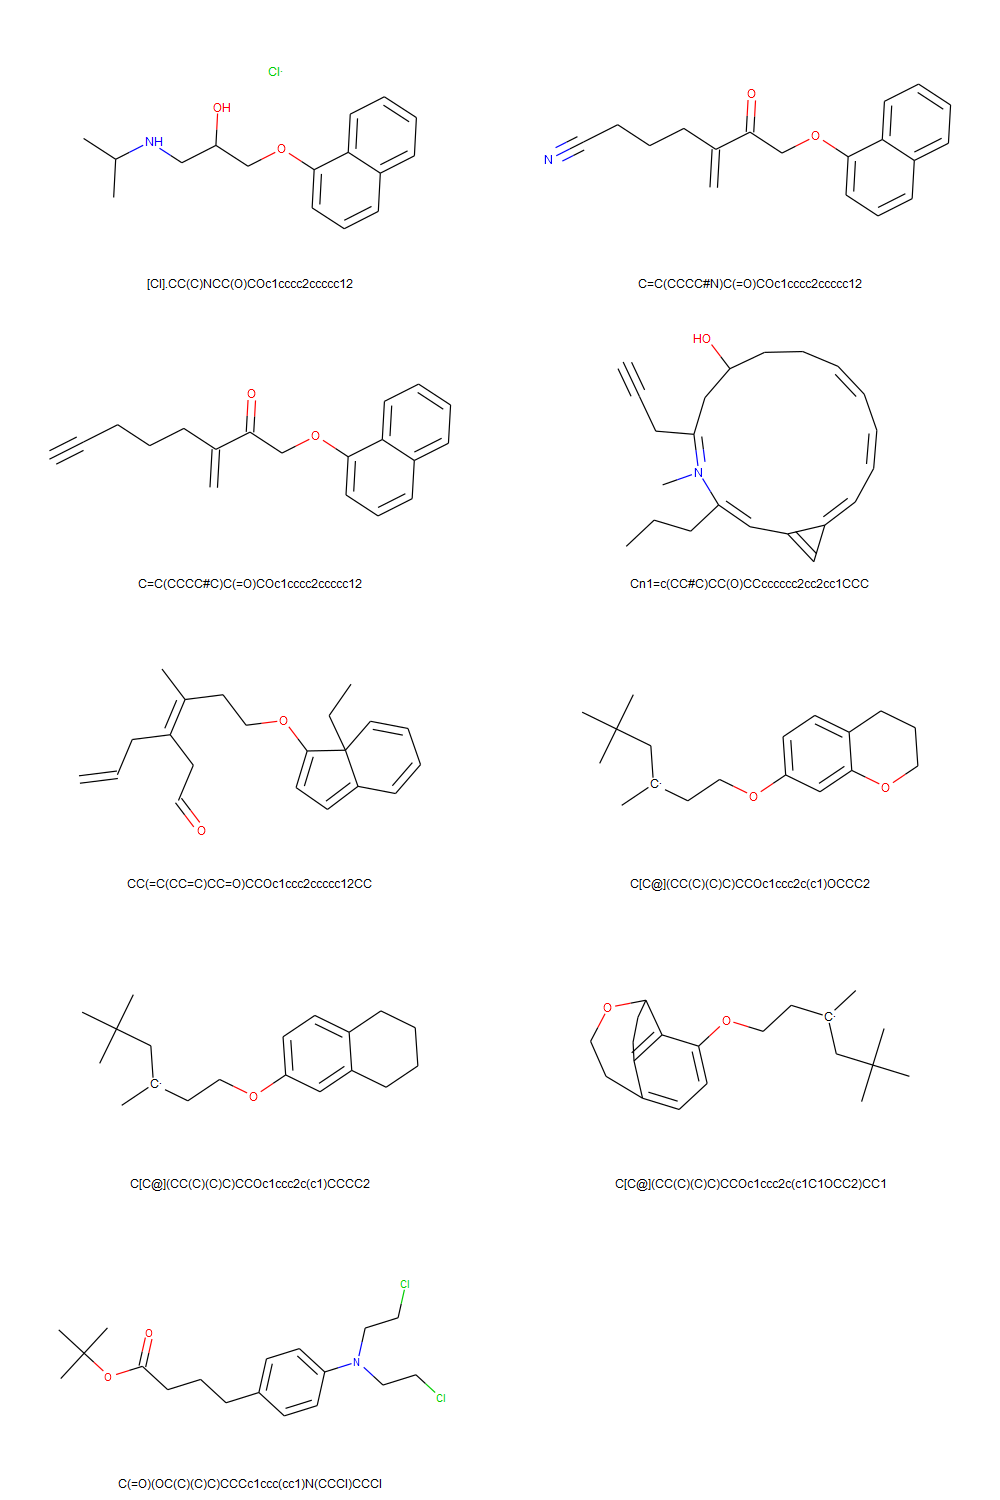

In [104]:
ms = [Chem.MolFromSmiles(smile) for smile in res]
[AllChem.Compute2DCoords(m) for m in ms]

Draw.MolsToGridImage(ms, 2, (500,300) , legends=res)